In [1]:
from models import *
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
print("Tensorflow version: ", tf.__version__)

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"

#Get Ticker and Period
ticker = 'clb'
period = "1wk"

# #Delete folders
shutil.rmtree(excel_reports)
shutil.rmtree(saved_models)
shutil.rmtree(trained_models)

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


Tensorflow version:  2.9.1


In [2]:
from transformers import PullData

#Initiate parameters
formation_window = 24
target_window = 4

#Do not change
window_size = formation_window + 1

#Print stuffs
print("window size: ",window_size)
print("formation_window: ",formation_window)
print("target_window: ",target_window)
print("chart period: ",period)

#training batches
batch_size_train = 8
batch_size_valid = 4

#Period model is trained and tested
start_date = '2020-01-01' #''2020-01-01   2015-01-01
end_date = '2022-09-04'  #'' 2022-08-17

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date, 
            end_date=end_date, 
            interval=period, #1wk
            progress=False,
            condition=False,####################################
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports
            )

data_prep = GetData.transform()

#Validation
if window_size != (formation_window + 1):
    raise Exception(f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
#data_prep

window size:  25
formation_window:  24
target_window:  4
chart period:  1wk
--------> PullData completed



In [3]:
####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                  export_excel=True, excel_path=excel_reports)

data_normalized, Dates = NormalizeData.transform(data_prep)

# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast


Dataframe shape:  (2825, 9)
Number of formations:  113
--------> NormalizeData completed



In [4]:
####################################################################

from training import SplitData

split_ratio = 0.80

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=True, excel_path=excel_reports)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)



Split ratio: 80 %
train period: 2019-12-30 - 2022-02-21
valid period: 2021-09-20 - 2022-08-01
x_train window:  90.0
x_valid window:  23.0
--------> SplitData completed



In [5]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



In [6]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



<b>Model Training</b>

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Get Model

In [8]:
tf.random.set_seed(7788)
np.random.seed(7788)
print(f"Model training - {str.upper(ticker)} \n")

model = clb_model()


# model = tf.keras.models.Sequential([

#         tf.keras.layers.Conv1D(filters=8, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                input_shape=[None, 7]),
#         tf.keras.layers.Conv1D(filters=16, kernel_size=1,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                #input_shape=[None, 7]
#                                ),
#         tf.keras.layers.Conv1D(filters=32, kernel_size=10,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                #input_shape=[None, 7]
#                                ),

#         tf.keras.layers.Bidirectional(
#             tf.keras.layers.LSTM(9, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),

#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.relu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(3, activation=tf.nn.selu),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(1, activation=tf.nn.relu),
#     ])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=8, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Model training - CLB 

Epoch 1/1200
12/12 [==============================] - 24s 880ms/step - loss: 0.1167 - val_loss: 0.1432 - lr: 0.0050
Epoch 2/1200
12/12 [==============================] - 1s 58ms/step - loss: 0.1075 - val_loss: 0.1347 - lr: 0.0050
Epoch 3/1200
12/12 [==============================] - 1s 54ms/step - loss: 0.1033 - val_loss: 0.1283 - lr: 0.0050
Epoch 4/1200
12/12 [==============================] - 1s 55ms/step - loss: 0.1002 - val_loss: 0.1230 - lr: 0.0050
Epoch 5/1200
12/12 [==============================] - 1s 54ms/step - loss: 0.0976 - val_loss: 0.1187 - lr: 0.0050
Epoch 6/1200
12/12 [==============================] - 1s 64ms/step - loss: 0.0956 - val_loss: 0.1149 - lr: 0.0050
Epoch 7/1200
12/12 [==============================] - 1s 43ms/step - loss: 0.0939 - val_loss: 0.1116 - lr: 0.0050
Epoch 8/1200
12/12 [==============================] - 1s 46ms/step - loss: 0.0925 - val_loss: 0.1087 - lr: 0.0050
Epoch 9/1200
12/12 [==============================] - 1s 43ms/s

In [9]:
# model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'
# model_name = 'Saved models\STNE_24_4_25_0.8_2020-01-01_2022-08-17.h5'
# model = tf.keras.models.load_model(model_name, custom_objects={
#                                              'sign_penalty': sign_penalty})


In [10]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


23/23 [==============================] - 5s 13ms/step


array([0.77880085, 0.78053784], dtype=float32)

In [11]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)
# predict = model.predict(pred)
# print("Raw prediction: ", predict)


In [12]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=window_size, debug=False)

df = ReverseNormalization.transform()
#df.head(25)

--------> ReverseNormalization completed



In [13]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

reversed_df = GetFinalDataframe.transform(df)
#reversed_df.head(25)


--------> GetFinalDataframe



In [14]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.head(25)


ticker: CLB

Formations:  23
period: 2021-09-20 - 2022-08-01
Entry Candle:  Current Open

Total Trades:  20
Profit Trades:  17
Loss Trades:  3

Win Ratio: 85.0 %
Loss Ratio: 15 %

Trade nr with exact TP:  13
Ratio of exact TP: 65.0 %

Average profit per trade:  620

Gross profit:  12403
Gross loss:  -6248

Net profit:  6155


In [15]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
# loss = trades_df[trades_df['profit']<0]
# loss['trade'].unique()
# trades_df.loc[trades_df['trade']==12]

Trade:  19
Window size:  25
Period: 2022-02-14 - 2022-07-25

Budget:  10000

Entry price:  18.38
Label (target):  19.02
Model prediction:  18.5
Market Change: 0.12 $
Profit: 65.29 $


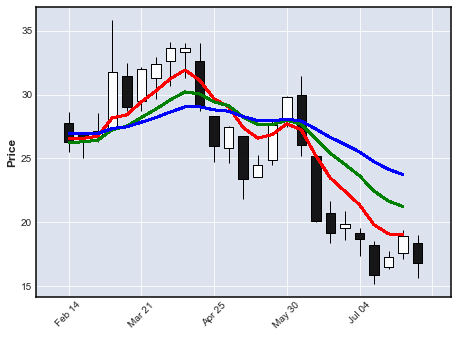

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
525,27.770000,28.639999,25.480000,26.280001,26.549443,26.240968,26.964501,nn,nn,2022-02-14,0.120884,19
526,26.990000,26.990000,25.000000,26.639999,26.575316,26.302358,26.938541,nn,nn,2022-02-21,0.120884,19
527,26.790001,28.530001,26.299999,27.139999,26.736654,26.431226,26.954658,nn,nn,2022-02-28,0.120884,19
528,27.420000,35.830002,27.309999,31.780001,28.177610,27.254114,27.340685,nn,nn,2022-03-07,0.120884,19
529,31.490000,32.459999,28.680000,29.000000,28.412579,27.522712,27.473430,nn,nn,2022-03-14,0.120884,19
530,29.500000,32.160000,28.750000,31.980000,29.431842,28.208448,27.833956,nn,nn,2022-03-21,0.120884,19
531,31.299999,32.900002,29.620001,32.430000,30.288459,28.857918,28.201639,nn,nn,2022-03-28,0.120884,19
532,32.660000,34.080002,30.639999,33.619999,31.240327,29.590546,28.635108,nn,nn,2022-04-04,0.120884,19
533,33.360001,34.060001,31.290001,33.610001,31.917377,30.208923,29.033099,nn,nn,2022-04-11,0.120884,19


In [16]:
trade = 19
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget)
trade += 1
df


In [17]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,26.270000,28.070000,26.030001,27.190001,28.113060,29.974975,31.471292,nn,nn,2021-09-20,5.147314,1,nn,nn
1,28.000000,30.430000,26.580000,29.049999,28.380757,29.832671,31.277589,nn,nn,2021-09-27,5.147314,1,nn,nn
2,29.730000,30.430000,27.219999,30.290001,28.926255,29.903030,31.198582,nn,nn,2021-10-04,5.147314,1,nn,nn
3,30.830000,32.220001,29.420000,31.540001,29.673040,30.154871,31.225895,nn,nn,2021-10-11,5.147314,1,nn,nn
4,30.190001,31.320000,28.000000,28.230000,29.260742,29.858737,30.986224,nn,nn,2021-10-18,5.147314,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,18.190001,18.549999,15.210000,15.880000,19.801003,22.442774,24.738753,nn,nn,2022-07-11,0.530001,20,nn,nn
496,16.469999,17.770000,16.360001,17.309999,19.089287,21.653116,24.144453,nn,nn,2022-07-18,0.530001,20,nn,nn
497,17.559999,19.420000,17.090000,18.940001,19.046634,21.235714,23.728097,nn,nn,2022-07-25,0.530001,20,nn,nn
498,18.379999,19.020000,16.110001,16.350000,18.276167,20.484065,23.137849,nn,nn,2022-08-01,0.530001,20,nn,nn


In [22]:
from final_evaluation import MakeSinglePrediction

#split_ratio = 0.8

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-09-04",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close')

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(24)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method



,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
53,2022-03-21,29.500000,32.160000,28.750000,31.980000,29.431842,28.206194,27.920627
54,2022-03-28,31.299999,32.900002,29.620001,32.430000,30.288459,28.856011,28.281377
55,2022-04-04,32.660000,34.080002,30.639999,33.619999,31.240327,29.588932,28.708467
56,2022-04-11,33.360001,34.060001,31.290001,33.610001,31.917377,30.207558,29.100590
57,2022-04-18,32.660000,34.020000,28.730000,29.170000,31.132412,30.047934,29.106143
58,2022-04-25,28.330000,28.330000,24.760000,26.000000,29.666009,29.425175,28.857651
59,2022-05-02,25.780001,27.540001,24.620001,27.469999,29.038577,29.124378,28.746639
60,2022-05-09,26.740000,26.740000,21.809999,23.360001,27.416127,28.237551,28.315708
61,2022-05-16,23.549999,25.250000,23.549999,24.520000,26.588662,27.665620,28.012051
62,2022-05-23,24.840000,28.049999,24.480000,27.580000,26.871902,27.652448,27.977487



Ticker:  clb

1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  16.93
Prediction:  18.08
Expected Market move:  1.15
Expected Profit:  682.4


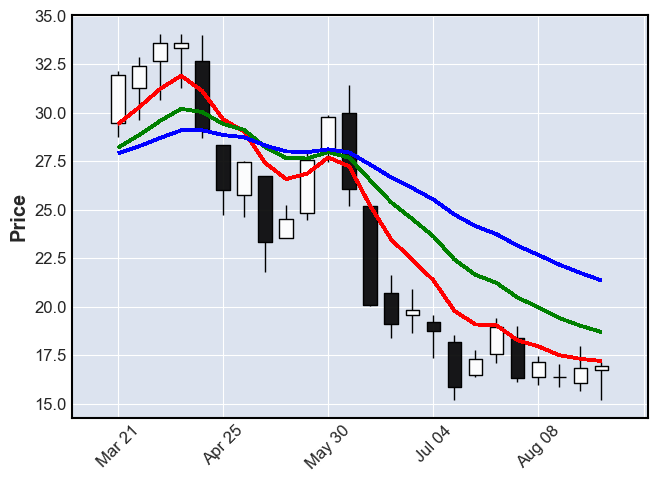

In [23]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart
from plotting import PlotCurrentFormation
PlotCurrentFormation(final_trade_formation)
#18.75

<b>Record Predictions</b>

In [25]:
final_df = pd.DataFrame()
#List all predictions
dicti_prediction1 = {'ticker':['STNSE'],'Date':['21.8.2022'],'prediction':['12.97 (should be penalized by 2 - 10.97)'],'real market move':['pending']}
dicti_prediction2 = {'ticker':['CLB'],'Date':['21.8.2022'],'prediction':['18.6'],'real market move':['pending']}
dicti_prediction3 = {'ticker':['MRK'],'Date':['27.8.2022'],'prediction':['93.23'],'real market move':['pending']}
dicti_prediction4 = {'ticker':['CLB'],'Date':['04.9.2022'],'prediction':['18.08'],'real market move':['pending']}

trades_tuple = (dicti_prediction1,dicti_prediction2,dicti_prediction3,dicti_prediction4)
for item in trades_tuple:
    df_pred = pd.DataFrame(item)
    final_df = final_df.append(df_pred)
final_df

,ticker,Date,prediction,real market move
0,STNSE,21.8.2022,12.97 (should be penalized by 2 - 10.97),pending
0,CLB,21.8.2022,18.6,pending
0,MRK,27.8.2022,93.23,pending
0,CLB,04.9.2022,18.08,pending


<b>Sentiment Analysis</b>

In [1]:
import requests
from termcolor import colored as cl
api_key = '631505e804ec58.42743136'

In [64]:
def get_customized_news(stock, start_date, end_date, n_news, api_key, offset = 0):
    url = f'https://eodhistoricaldata.com/api/news?api_token={api_key}&s={stock}&limit={n_news}&offset={offset}&from={start_date}&to={end_date}'
    news_json = requests.get(url).json()
    
    news = []
    
    for i in range(len(news_json)):
        title = news_json[-i]['title']
        news.append(title)
        #print(cl('{}. '.format(i+1), attrs = ['bold']), '{}'.format(title))
    
    return news,news_json

clb_news,json = get_customized_news('clb', '2021-09-01', '2022-09-04', 15, api_key, 0)
json

[{'date': '2022-08-24T10:20:39+00:00',
  'title': "Should You Be Concerned About Core Laboratories N.V.'s (NYSE:CLB) ROE?",
  'content': "Many investors are still learning about the various metrics that can be useful when analysing a stock. This article is for those who would like to learn about Return On Equity (ROE). To keep the lesson grounded in practicality, we'll use ROE to better understand Core Laboratories N.V. (NYSE:CLB).\n\nReturn on Equity or ROE is a test of how effectively a company is growing its value and managing investors’ money. Put another way, it reveals the company's success at turning shareholder investments into profits.\n\nSee our latest analysis for Core Laboratories\n\nHow Is ROE Calculated?\n\nThe formula for ROE is:\n\nReturn on Equity = Net Profit (from continuing operations) ÷ Shareholders' Equity\n\nSo, based on the above formula, the ROE for Core Laboratories is:\n\n5.2% = US$9.1m ÷ US$174m (Based on the trailing twelve months to June 2022).\n\nThe 'ret

In [66]:
# import json
  
# # Opening JSON file
# f = open('json.json')
  
# # returns JSON object as 
# # a dictionary
# data = json.load(f)
# for i in data:
#     print(i)
#json

In [98]:
import pandas as pd
news_df = pd.DataFrame()

for item in json:
    #extract data
    date = item['date']
    title = item['title'] 
    content = item['content']
    sentiment = item['sentiment']['polarity']
    dicti = {'Date':[date],'Title':[title],'Content':[content],'API Sentiment':[sentiment]}
    #append to dataframe
    temp_df = pd.DataFrame(dicti)
    news_df = pd.concat([temp_df,news_df],axis=0)

news_df['Date'] = news_df['Date'].astype('datetime64[ns]')
news_df['Date'] = [x.strftime("%d/%m/%Y") for x in news_df['Date']]
news_df

,Date,Title,Content,API Sentiment
0,19/07/2022,Implied Volatility Surging for Core Laboratori...,Investors in Core Laboratories N.V. CLB need t...,0.986
0,19/07/2022,"Stocks rise, commodities at inflection point, ...",Yahoo Finance’s Jared Blikre breaks down how m...,0.000
0,20/07/2022,Earnings Preview: Core Laboratories (CLB) Q2 E...,Wall Street expects a year-over-year decline i...,0.998
0,26/07/2022,SEC Seeks More Details From Companies on Russi...,The Securities and Exchange Commission continu...,-0.402
0,26/07/2022,SEC Presses Some Companies for Details on Russ...,The Securities and Exchange Commission is pres...,-0.751
0,27/07/2022,CORE LAB REPORTS SECOND QUARTER 2022 RESULTS F...,SECOND QUARTER REVENUE OF $120.9 MILLION; UP 5...,1.000
0,27/07/2022,Core Laboratories (CLB) Q2 Earnings Match Esti...,Core Laboratories (CLB) came out with quarterl...,0.994
0,28/07/2022,Why Core Laboratories Stock Sank Today,Investors weren't in a particularly forgiving ...,-0.162
0,29/07/2022,Core Laboratories (CLB) Q2 2022 Earnings Call ...,"This morning, I'm joined by Chris Hill, Core's...",0.000
0,01/08/2022,"Core Labs (CLB) Q2 Earnings Meet Estimates, Sa...",Core Laboratories CLB reported second-quarter ...,0.995


In [105]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
news_df['VaderSentiment'] = 0
vader = SentimentIntensityAnalyzer()

for row in range(news_df.shape[0]):
    title = news_df.iloc[row,1]
    title = f'"{title}"'
    content = news_df.iloc[row,2] 
    #print(title)
    score = vader.polarity_scores(title)
    compound_score = score['compound']
    # print(score)
    # print(compound_score)
    news_df.iloc[row,4] = compound_score
    
news_df

,Date,Title,Content,API Sentiment,VaderSentiment
0,19/07/2022,Implied Volatility Surging for Core Laboratori...,Investors in Core Laboratories N.V. CLB need t...,0.986,0.0000
0,19/07/2022,"Stocks rise, commodities at inflection point, ...",Yahoo Finance’s Jared Blikre breaks down how m...,0.000,0.0000
0,20/07/2022,Earnings Preview: Core Laboratories (CLB) Q2 E...,Wall Street expects a year-over-year decline i...,0.998,0.0000
0,26/07/2022,SEC Seeks More Details From Companies on Russi...,The Securities and Exchange Commission continu...,-0.402,-0.5859
0,26/07/2022,SEC Presses Some Companies for Details on Russ...,The Securities and Exchange Commission is pres...,-0.751,-0.5859
0,27/07/2022,CORE LAB REPORTS SECOND QUARTER 2022 RESULTS F...,SECOND QUARTER REVENUE OF $120.9 MILLION; UP 5...,1.000,0.0000
0,27/07/2022,Core Laboratories (CLB) Q2 Earnings Match Esti...,Core Laboratories (CLB) came out with quarterl...,0.994,0.0000
0,28/07/2022,Why Core Laboratories Stock Sank Today,Investors weren't in a particularly forgiving ...,-0.162,0.0000
0,29/07/2022,Core Laboratories (CLB) Q2 2022 Earnings Call ...,"This morning, I'm joined by Chris Hill, Core's...",0.000,0.0000
0,01/08/2022,"Core Labs (CLB) Q2 Earnings Meet Estimates, Sa...",Core Laboratories CLB reported second-quarter ...,0.995,0.0000


In [90]:
clb_news

["Should You Be Concerned About Core Laboratories N.V.'s (NYSE:CLB) ROE?",
 'Implied Volatility Surging for Core Laboratories (CLB) Stock Options',
 'Stocks rise, commodities at inflection point, crypto fallout continues',
 'Earnings Preview: Core Laboratories (CLB) Q2 Earnings Expected to Decline',
 'SEC Seeks More Details From Companies on Russia-Linked Losses, Risks',
 'SEC Presses Some Companies for Details on Russia-Linked Losses, Risks',
 'CORE LAB REPORTS SECOND QUARTER 2022 RESULTS FROM CONTINUING OPERATIONS',
 'Core Laboratories (CLB) Q2 Earnings Match Estimates',
 'Why Core Laboratories Stock Sank Today',
 'Core Laboratories (CLB) Q2 2022 Earnings Call Transcript',
 'Core Labs (CLB) Q2 Earnings Meet Estimates, Sales Narrowly Beat',
 'Why Energy Stocks Dropped on Monday',
 'SLB or CLB: Which Is the Better Value Stock Right Now?',
 'Why Devon Energy, Tellurian, and Core Laboratories Stocks Rocketed Higher Today',
 'SLB vs. CLB: Which Stock Should Value Investors Buy Now?']

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

for i in clb_news:
    score = vader.polarity_scores(i)['compound']
    if score != 0:
        print(f'Evaluated title: \n{i}')
        print(f'Score is: {score}\n')
   # print(f'Score: {vader.polarity_scores(i)['compound']}')

Evalauated title: 
SEC Seeks More Details From Companies on Russia-Linked Losses, Risks
Score is: -0.5859

Evalauated title: 
SEC Presses Some Companies for Details on Russia-Linked Losses, Risks
Score is: -0.5859

Evalauated title: 
Why Energy Stocks Dropped on Monday
Score is: 0.2732

Evalauated title: 
SLB or CLB: Which Is the Better Value Stock Right Now?
Score is: 0.6486

Evalauated title: 
Why Devon Energy, Tellurian, and Core Laboratories Stocks Rocketed Higher Today
Score is: 0.2732

Evalauated title: 
SLB vs. CLB: Which Stock Should Value Investors Buy Now?
Score is: 0.34

